<a href="https://colab.research.google.com/github/Prachiy031/FinalYearProject/blob/main/ksdImple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing All Libraries

In [10]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [11]:
!pip install --upgrade tensorflow keras


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gradio as gr
from tensorflow.keras.callbacks import EarlyStopping


**Preparing For Data**

In [13]:
from google.colab import drive              # mounted to drive so to access everything from drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
folder_path = "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train"
filenames = []      #stores relative paths of image
categories = []     #stores category/label of image...e.g. stone ,normal

for category in os.listdir(folder_path):    #gets a list of all subfolders inside Train
    category_path = os.path.join(folder_path, category)  #joins folder path and each category in category folder

    if os.path.isdir(category_path):  #valid directory
        for filename in os.listdir(category_path):   #loop through all images in category_path
            filenames.append(os.path.join(category, filename))    #joins filename to category and append it to filenames list
            categories.append(category)   #category is appended to categories list

df = pd.DataFrame({            #structured dataframe
    'filename': filenames,
    'category': categories
})

In [11]:
df.head()             #top 5 entries

,filename,category
0,Stone/Stone- (104).jpg,Stone
1,Stone/Stone- (111).jpg,Stone
2,Stone/Stone- (108).jpg,Stone
3,Stone/Stone- (107).jpg,Stone
4,Stone/Stone- (11).jpg,Stone


In [12]:
df.tail()          #last 5 entries

,filename,category
2995,Normal/Normal- (2148).jpg,Normal
2996,Normal/Normal- (215).jpg,Normal
2997,Normal/Normal- (2165).jpg,Normal
2998,Normal/Normal- (2144).jpg,Normal
2999,Normal/Normal- (2154).jpg,Normal


<Axes: xlabel='category'>

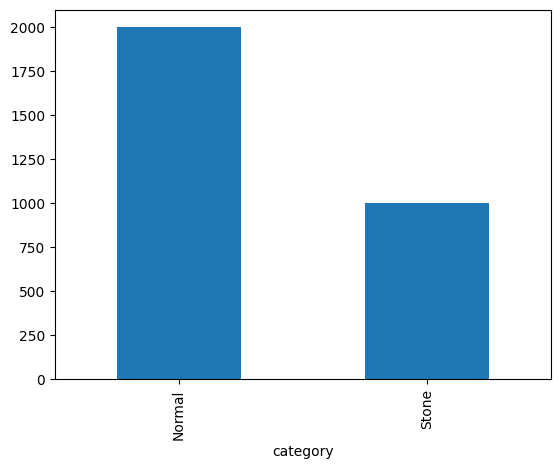

In [13]:
df['category'].value_counts().plot.bar()

There are total 2000 normal and 1000 stone images in dataset

**Visualizing Data**

Selected file: Normal/Normal- (2007).jpg


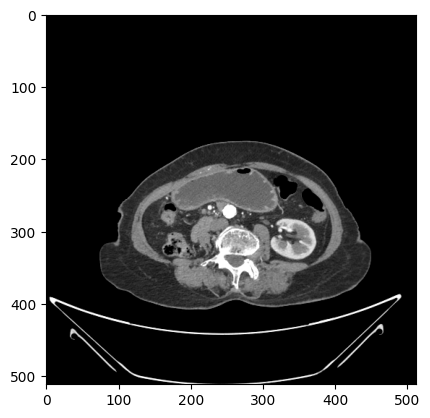

In [16]:
sample = random.choice(filenames)    #selects random file from filenames list
print("Selected file:", sample)       #selected file
image = load_img("/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/"+sample)       #reads an image (keras utility function)
plt.imshow(image)  #renders an image in colab (matplotlib)

**Building CNN Model**

In [15]:
model = Sequential()      #model in linear stack of layers, each layer has exactly one i/p and o/p tensor

#Adding convolutional layers
# 32-no. of kernels/filters (3,3)- size of each filter activation function is relu for no-linearity
# i/p image of shape(150,150,3)...150*150 with 3 channels of RGB color images
#this layers applies 32 filters to i/p image eah with 3*3 in size to extract features like edges,textures,patterns
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())   #improve the training speed and stability of neural network
model.add(MaxPooling2D(pool_size=(2, 2)))   #reduces the spatial dimensions(height and width) by selecting max value from 2*2 pool
#it encourages the model to focus on the most important features of the image, rather than memorizing detailed spatial information.
#selects max out of 2*2 widow size



#Adding a second convolutional layer
#with 64 filters/kernels    no need to mention i/p shape as it is inferred from prev layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors which are used in fully connected layers...3d vector with dim (h,w,channels) will be reshaped into h*w*channels
model.add(Dense(128, activation='relu'))          #fully connected layer with 128 neurons
model.add(BatchNormalization())
model.add(Dropout(0.5))  #50% neurons are randomly dropped to prevent overfitting during training
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2...adds a fully connected layer to neural network with 2 neurons in that layer
model.add(Activation('softmax')) #2 output neurons with softmax for binary classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)


**Call backs => early stop to prevent overfitting after 10 epochs by halting training when the model's performance on the validation set ceases to improve.**






In [16]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#The callback will monitor the validation loss during training (It represents the error (or loss) of the model when it is evaluated on the validation set)
#The model will wait for 10 epochs without improvement in validation loss before stopping.
#When training stops, it restores the model weights to the point with the best performance on the validation set.


**Learning Rate Reduction
We will reduce the learning rate when accuracy is not increasing for 2 steps**

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


#helps the model learn better when progress slows down, without stopping training entirely.


In [18]:
callbacks = [earlystop, learning_rate_reduction]    #list of callbacks that will be used during model training

**Preparing Data
1)split dataset into training set 80% and validation set 20%**

In [19]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


#random_state is set to 42 so that everytime we run the code ,train-test spilt will remian same , otherwise it will change
#also there will be no different model performance each time
#after splitting indices will be reset again starting from 0

<Axes: xlabel='category'>

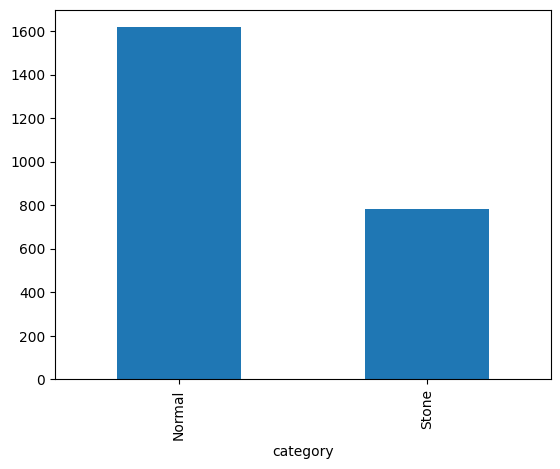

In [20]:
train_df['category'].value_counts().plot.bar()

**for training there are 1600 normal images and 800 stone images**

<Axes: xlabel='category'>

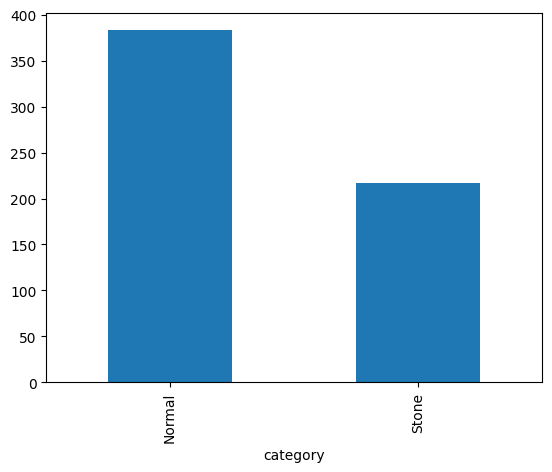

In [21]:
validate_df['category'].value_counts().plot.bar()

**for validation there are 375 normal images and 225 stone images**

**Train and validation generator
1)with generator memory usage is less , data augmentation is auto and label handling is automatic and fast efficiency**

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,          #randomly rotates image upto +-15 degree
    rescale=1./255,              #Scales pixel values to the range [0,1] (instead of [0,255]), which helps with faster and stable training.
    shear_range=0.1,      #Applies a shear transformation (tilts the image)
    zoom_range=0.2,       #Randomly zooms the image in or out by up to 20%
    horizontal_flip=True, #Randomly flips images horizontally.
    width_shift_range=0.1,  #Shifts the image horizontally by up to 10%.
    height_shift_range=0.1  #Shifts the image vertically by up to 10%
)

#image data generator in keras is used for data augmentation which helps to increase the diversity of training images by applying random transformations
#improves model generalization and reduces overfitting.

validation_datagen = ImageDataGenerator(rescale=1./255)    #Converts pixel values from [0,255] to [0,1]

In [23]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),     #resizes all images to 150*150
    class_mode='categorical',       #converts labels into one-hot encoded format
    batch_size=15   #generator loads images in batches of 15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),    #resizes all images to 150*150
    class_mode='categorical',    #converts labels into one-hot encoded format
    batch_size=15
)


#flow_from_dataframe uses a Pandas dataframe containing file names & labels.
#Can load images from multiple sources without changing directory structure.
# Allows custom class labels directly from a CSV or dataframe.

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


**Visualizing the output of data generator**

In [24]:
example_df = train_df.sample(n=1).reset_index(drop=True)   #select one random image from train_df and reset index so that row will start from 0

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


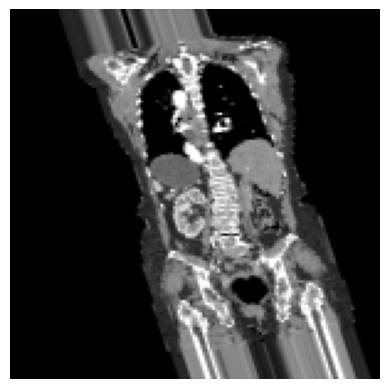

Class Label (One-Hot Encoded): [1.]


In [25]:
#view randomly selected image

# Get a batch (1 image) from the generator
image_batch, label_batch = next(example_generator)  #retrives next batch of images and labels
#image batch=>numpy array of images
#label_batch =>numpy array of one-hot encoded lables
# Display the image
plt.imshow(image_batch[0])  # Display first (and only) image
plt.axis("off")  # Hide axes
plt.show()

# Print the corresponding label
print("Class Label (One-Hot Encoded):", label_batch[0])


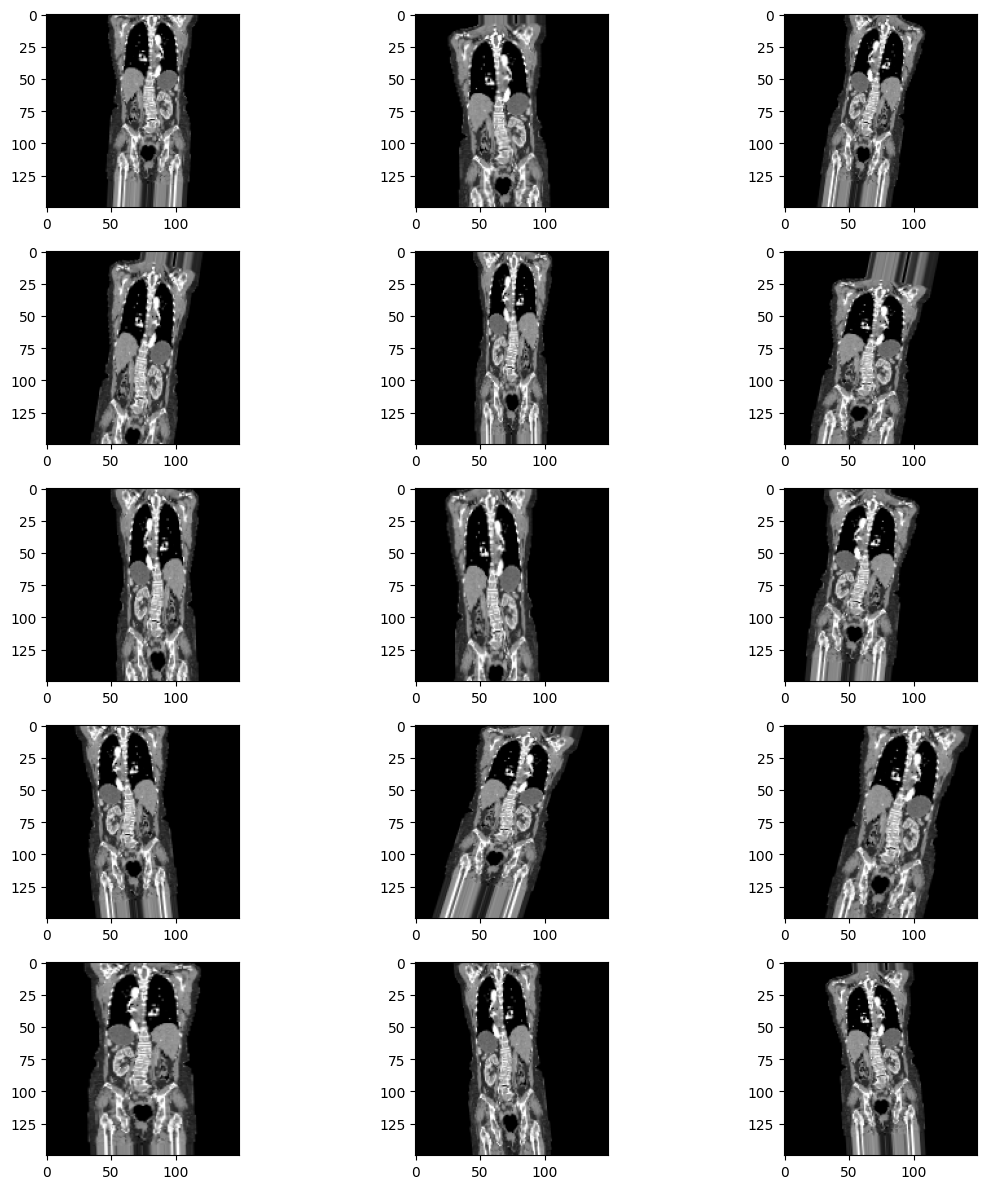

In [26]:
plt.figure(figsize=(12, 12)) #sets size of entire fig 12*12 inches
for i in range(0, 15):   #displaying total 15 images
    plt.subplot(5, 3, i+1) #5 rows 3 colm
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()  #Ensure subplots do not overlap
plt.show()